# Pré-traitement des données
Voici quelques étapes à suivre pour pré-traiter les données pour une utilisation avec K-means :

1. Intégration des données : Intégrez les données des différentes sources en une seule source de données. Si vous travaillez avec des données provenant de plusieurs sources, vous devez les intégrer en une seule source de données. Cela vous permettra de traiter les données comme une seule entité et de les analyser plus facilement.

1. Nettoyer les données : Assurez-vous que vos données sont propres et ne contiennent pas de valeurs manquantes, de doublons ou d'autres anomalies. Si nécessaire, supprimez ou remplacez les données manquantes.

2. Normaliser les données : Normalisez les données en les mettant à l'échelle de sorte que chaque variable ait une plage de valeurs comparable. La normalisation peut être effectuée en utilisant la méthode de la moyenne et de l'écart type, la méthode de la plage ou la méthode de la normalisation de l'amplitude.

3. Réduire la dimensionnalité : Si vous travaillez avec des données à haute dimensionnalité, utilisez des techniques de réduction de dimensionnalité telles que l'analyse en composantes principales (PCA) pour réduire la dimensionnalité de vos données et faciliter leur analyse.

4. Identifier les valeurs aberrantes : Les valeurs aberrantes peuvent fausser les résultats de K-means, il est donc important de les identifier et de les traiter correctement. Les valeurs aberrantes peuvent être supprimées ou remplacées par des valeurs plus appropriées.

5. Sélectionner les caractéristiques : Si vous travaillez avec des données qui contiennent de nombreuses caractéristiques, il peut être judicieux de sélectionner les caractéristiques les plus pertinentes pour votre analyse.

En résumé, le pré-traitement des données pour K-means comprend le nettoyage des données, la normalisation des données, la réduction de la dimensionnalité, l'identification et le traitement des valeurs aberrantes et la sélection des caractéristiques. En effectuant ces étapes, vous pouvez améliorer la qualité de vos données et obtenir des résultats plus significatifs à l'aide de K-means.

## Pipeline
La pipeline fait référence à un ensemble d'étapes ou de processus qui sont exécutés séquentiellement pour traiter les données d'entrée, extraire des caractéristiques, entraîner le modèle et prédire les résultats.

In [1]:
import pandas as pd
import numpy as np
import os
from copy import deepcopy

# Settings
pd.set_option('display.max_columns', None)

# Global variables
GENERAL_DATA_PATH = "./data/general_data.csv"
EMPLOYEE_SURVEY_DATA_PATH = "./data/employee_survey_data.csv"
MANAGER_SURVEY_DATA_PATH = "./data/manager_survey_data.csv"
IN_TIME_DATA_PATH = "./data/in_out_time/in_time.csv"
OUT_TIME_DATA_PATH = "./data/in_out_time/out_time.csv"

## Acquisition des données
Collecter des données brutes à partir de diverses sources, telles que des capteurs, des fichiers, des bases de données, etc.

In [2]:
def load_data(data_path):
    csv_path = os.path.join(data_path)
    return pd.read_csv(csv_path, sep=',')

def agregate_dataframes(list_df, on_column, how):
    df_master = list_df[0]
    for df in list_df[1:]:
        df_master = df_master.merge(df,
                       on = on_column, 
                       how = how)
    return df_master

def avg_time(df):
    '''
    Calculate the average time of in_time and out_time.

    Parameters
    ----------
    df : pandas.DataFrame
        Dataframe with in_time or out_time.
    
    Returns
    -------
    df : pandas.DataFrame
        Dataframe with EmployeeID and AvgTime.
    '''
    # Set first column as index
    df = df.copy().set_index(df.columns[0])
    # Remove first column
    df = df.copy().transpose()

    # Convertir les valeurs datetime en valeurs time
    df = df.apply(pd.to_datetime)
    df = df.apply(lambda x: x - x.dt.normalize())
    df = df.mean(skipna=True)
    # Add column EmployeeID
    df = df.to_frame().reset_index()
    df.columns = ["EmployeeID", "AvgTime"]
    return df

# Load data
df_general = load_data(GENERAL_DATA_PATH)
df_employee_survey = load_data(EMPLOYEE_SURVEY_DATA_PATH)
df_manager_survey = load_data(MANAGER_SURVEY_DATA_PATH)
df_in_time = load_data(IN_TIME_DATA_PATH)
df_out_time = load_data(OUT_TIME_DATA_PATH)
# Merge dataframes
df_total = agregate_dataframes(
    [df_general, df_employee_survey, df_manager_survey],
    "EmployeeID",
    "outer"
)

# --- HANDLE IN AND OUT TIME ---
# Get average in time
avg_in_time_per_employee = avg_time(df_in_time)
# Get average out time
avg_out_time_per_employee = avg_time(df_out_time)
# Merge in and out time
avg_work_time_per_employee = avg_out_time_per_employee.copy()
avg_work_time_per_employee["AvgTime"] = avg_out_time_per_employee["AvgTime"] - avg_in_time_per_employee["AvgTime"]
avg_work_time_per_employee["AvgTime"] = avg_work_time_per_employee["AvgTime"].apply(lambda x: x.total_seconds() / 3600)

# Merge with total dataframe
df_total = df_total.merge(
    avg_work_time_per_employee,
    on = "EmployeeID",
    how = "outer"
)

# Display a random sample of 5 rows
df_total.sample(5)

,Age,Attrition,BusinessTravel,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeID,Gender,JobLevel,JobRole,MaritalStatus,MonthlyIncome,NumCompaniesWorked,Over18,PercentSalaryHike,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgTime
2061,43,Yes,Travel_Rarely,Sales,5,3,Marketing,1,2062,Female,3,Research Scientist,Single,45220,8.0,Y,15,8,1,7.0,3,4,1,3,1.0,3.0,2.0,3,3,7.502324
1434,37,No,Travel_Frequently,Sales,2,4,Life Sciences,1,1435,Male,2,Laboratory Technician,Divorced,52380,1.0,Y,15,8,1,10.0,5,10,0,7,2.0,4.0,3.0,3,3,10.134707
1803,33,Yes,Travel_Rarely,Research & Development,23,5,Life Sciences,1,1804,Male,1,Human Resources,Single,86390,5.0,Y,16,8,2,6.0,3,3,0,2,1.0,1.0,3.0,2,3,8.022935
1398,40,No,Travel_Rarely,Research & Development,11,3,Life Sciences,1,1399,Female,2,Sales Executive,Married,70050,1.0,Y,20,8,2,21.0,2,20,9,9,4.0,3.0,3.0,3,4,6.206365
3331,53,No,Travel_Rarely,Research & Development,1,1,Medical,1,3332,Male,1,Sales Executive,Single,44250,6.0,Y,22,8,1,33.0,2,12,3,8,4.0,4.0,3.0,4,4,6.700678


## Prétraitement des données

Nettoyer, normaliser et préparer les données pour l'analyse ultérieure.

### Nettoyage des données

Une étude préablable a permis de déterminer quels champs n'apportaient pas d'informations utiles à la prédiction. De même pour les champs non éthiques.

In [3]:
fields_not_useful = [
    "Over18",  # We have age
    "EducationField",  # We have Education
    "EmployeeCount",  # All at 1
    "StockOptionLevel",  # Not relevant
]
fields_not_ethical = [
    "Gender",
    "MaritalStatus",
]

# Datframe with only useful fields
df_useful = deepcopy(df_total)
df_useful.drop(
    fields_not_useful,
    axis=1,
    inplace=True
)
print("Shape useful:", df_useful.shape)

# Datframe with useful and ethical fields
df_ethical = deepcopy(df_total)
df_ethical.drop(
    fields_not_useful + fields_not_ethical,
    axis=1,
    inplace=True
)
print("Shape useful:", df_ethical.shape)

# Delete to free memory
del df_total
del fields_not_useful
del fields_not_ethical

Shape useful: (4410, 26)
Shape useful: (4410, 24)


### Normalisation des données

In [4]:
# List of columns to merge to add columns
columns_to_merge = [
    ("TotalWorkingYears", "Age"),
    ("YearsAtCompany", "Age"),
    ("NumCompaniesWorked", "Age"),
    ("YearsSinceLastPromotion", "Age"),
    ("YearsWithCurrManager", "Age"),
    ("YearsAtCompany", "TotalWorkingYears"),
    ("YearsSinceLastPromotion", "TotalWorkingYears"),
    ("YearsWithCurrManager", "TotalWorkingYears"),
]
column_ids_to_merge = []

In [5]:
from sklearn.model_selection import StratifiedShuffleSplit

def split_train_test(data, test_ratio):
    """
    Split the data into a training set and a test set.
    """
    split = StratifiedShuffleSplit(n_splits=1, test_size=test_ratio, random_state=42)
    for train_index, test_index in split.split(data, data["Attrition"]):
        strat_train_set = data.loc[train_index]
        strat_test_set = data.loc[test_index]
    return strat_train_set, strat_test_set

# Split train and test sets
useful_train_set, useful_test_set = split_train_test(df_useful, 0.2)
ethical_train_set, ethical_test_set = split_train_test(df_ethical, 0.2)

In [6]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, column_ids_to_merge=[]):
        self.column_ids_to_merge = column_ids_to_merge
    def fit(self, X, y=None):
        return self  # nothing else to do
    def transform(self, X, y=None):
        if len(column_ids_to_merge) == 0:
            return X
        new_columns = []
        for ctm in column_ids_to_merge:
            col_1 = X[:, ctm[0]]
            col_2 = X[:, ctm[1]]
            # index1 * index2
            new_columns.append(col_1 * col_2)
        return np.c_[X, *new_columns]

def get_named_columns(columns: list[tuple[str]]=columns_to_merge) -> list[str]:
    """
    Return a list of columns names with the format "column1PerColumn2"
    """
    named_columns = []
    for ctm in columns:
        named_columns.append(ctm[0] + "Per" + ctm[1])
    return named_columns

def get_columns_ids(names: list[str], columns: list[tuple[str]]=columns_to_merge) -> list[tuple[int]]:
    """
    Return a list of columns ids from names (only if the column name is in "columns").
    """
    column_ids = []
    for c in columns:
        tuple_ids = tuple()
        for index in c:
            tuple_ids += (names.index(index),)
        column_ids.append(tuple_ids)
    return column_ids

def name_categories(columns: list[str], categories: list[list[str]]) -> list[str]:
    """
    Name the categories of the columns.
    """
    named_categories = []
    for index in range(len(columns)):
        col_categories = categories[index]
        col_name = columns[index]
        named_categories.extend([
            col_name + "_" + str(c).replace(' ', '_') for c in col_categories
        ])
    return named_categories

In [7]:
# -- Useful --
useful_train_set_num = useful_train_set.select_dtypes(include=[np.number])
useful_num_attribs = list(useful_train_set_num.keys())
column_ids_to_merge = get_columns_ids(useful_num_attribs)  # ids for useful set

# Create the pipeline for numerical attributes
num_pipeline_useful = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder(column_ids_to_merge)),
    ('std_scaler', StandardScaler()),
])

# List of categorical attributes
useful_cat_attribs = ["BusinessTravel", "Department", "JobRole", "Gender", "MaritalStatus",]

# Full pipeline
useful_full_pipeline = ColumnTransformer([
    ("num", num_pipeline_useful, useful_num_attribs),
    ("cat", OneHotEncoder(), useful_cat_attribs),
])

In [8]:
# -- Ethical And Useful --
ethical_train_set_num = ethical_train_set.select_dtypes(include=[np.number])
ethical_num_attribs = list(ethical_train_set_num.keys())
column_ids_to_merge = get_columns_ids(ethical_num_attribs)  # ids for ethical set

# Create the pipeline for numerical attributes
num_pipeline_ethical = Pipeline([
    ('imputer', SimpleImputer(strategy="median")),
    ('attribs_adder', CombinedAttributesAdder(column_ids_to_merge)),
    ('std_scaler', StandardScaler()),
])

# List of categorical attributes
ethical_cat_attribs = ["BusinessTravel", "Department", "JobRole"]

# Full pipeline
ethical_full_pipeline = ColumnTransformer([
    ("num", num_pipeline_ethical, ethical_num_attribs),
    ("cat", OneHotEncoder(), ethical_cat_attribs),
])

In [9]:
# -- Useful --
useful_train_set_prepared = useful_full_pipeline.fit_transform(useful_train_set)
# -- Ethical --
ethical_train_set_prepared = ethical_full_pipeline.fit_transform(ethical_train_set)

# Collect the categories values
useful_cat_raw = useful_full_pipeline.named_transformers_['cat'].categories_

In [10]:
# Convert to dataframe with named columns
# -- Useful --
useful_cat_attribs = name_categories(useful_cat_attribs, useful_cat_raw)
useful_columns = useful_num_attribs + get_named_columns() + useful_cat_attribs
useful_train_set_prepared_df = pd.DataFrame(
    useful_train_set_prepared, columns=useful_columns
)
# -- Ethical --
ethical_cat_attribs = name_categories(ethical_cat_attribs, useful_cat_raw)
ethical_columns = ethical_num_attribs + get_named_columns() + ethical_cat_attribs
ethical_train_set_prepared_df = pd.DataFrame(
    ethical_train_set_prepared, columns=ethical_columns
)

In [11]:
print("Useful set:")
useful_train_set_prepared_df.sample(5)

Useful set:


,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgTime,TotalWorkingYearsPerAge,YearsAtCompanyPerAge,NumCompaniesWorkedPerAge,YearsSinceLastPromotionPerAge,YearsWithCurrManagerPerAge,YearsAtCompanyPerTotalWorkingYears,YearsSinceLastPromotionPerTotalWorkingYears,YearsWithCurrManagerPerTotalWorkingYears,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human_Resources,Department_Research_&_Development,Department_Sales,JobRole_Healthcare_Representative,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative,Gender_Female,Gender_Male,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single
1824,1.783154,-0.403267,1.05518,-1.252472,-0.969757,-0.519185,0.119915,-0.884371,0.0,1.903358,0.162575,0.011236,0.589091,0.818235,1.177689,0.263919,0.33777,-1.035108,-0.432065,-1.271775,2.202851,0.347051,0.491183,0.925681,1.413704,0.440297,0.991636,1.569203,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1327,0.133136,1.927464,-1.87606,1.703190,-0.969757,0.288672,0.119915,-0.341374,0.0,-0.289795,0.162575,0.011236,-0.360633,0.818235,1.177689,1.169667,-2.52678,1.797989,-0.432065,-0.305767,-0.289037,-0.019912,0.072538,-0.339880,0.721688,-0.255586,-0.347896,0.059485,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0
496,-0.856874,-0.893948,1.05518,0.588217,-0.969757,-0.805407,-0.279952,-0.069875,0.0,-0.160786,-0.615667,-0.652203,-0.677208,-0.584999,1.177689,1.169667,0.33777,-1.035108,-0.432065,-1.207984,-0.414113,-0.645497,-0.448443,-0.616267,-0.649162,-0.448562,-0.474799,-0.486043,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
1020,2.113158,-1.016618,-0.89898,1.454980,2.636359,-0.830811,-0.679818,1.559116,0.0,-0.805831,0.162575,-0.486343,-0.360633,-1.146292,-1.581810,1.169667,0.33777,0.381440,2.314467,-0.602707,-0.438166,-0.166698,-0.467049,-0.208960,-1.031418,-0.507039,-0.404298,-0.739777,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0
706,0.463140,-1.016618,0.07810,0.557487,-0.068228,0.084591,0.119915,1.016119,0.0,0.613268,0.162575,-0.983923,-0.677208,-1.146292,1.177689,1.169667,0.33777,-1.035108,-0.432065,1.027422,0.466226,-0.806262,0.156267,-0.616267,-1.031418,-0.530430,-0.474799,-0.739777,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [12]:
print("Ethical set:")
ethical_train_set_prepared_df.sample(5)

Ethical set:


,Age,DistanceFromHome,Education,EmployeeID,JobLevel,MonthlyIncome,NumCompaniesWorked,PercentSalaryHike,StandardHours,TotalWorkingYears,TrainingTimesLastYear,YearsAtCompany,YearsSinceLastPromotion,YearsWithCurrManager,EnvironmentSatisfaction,JobSatisfaction,WorkLifeBalance,JobInvolvement,PerformanceRating,AvgTime,TotalWorkingYearsPerAge,YearsAtCompanyPerAge,NumCompaniesWorkedPerAge,YearsSinceLastPromotionPerAge,YearsWithCurrManagerPerAge,YearsAtCompanyPerTotalWorkingYears,YearsSinceLastPromotionPerTotalWorkingYears,YearsWithCurrManagerPerTotalWorkingYears,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely,Department_Human_Resources,Department_Research_&_Development,Department_Sales,JobRole_Healthcare_Representative,JobRole_Human_Resources,JobRole_Laboratory_Technician,JobRole_Manager,JobRole_Manufacturing_Director,JobRole_Research_Director,JobRole_Research_Scientist,JobRole_Sales_Executive,JobRole_Sales_Representative
2681,2.333160,1.804794,0.07810,-0.301397,-0.068228,-0.458638,1.719381,0.473122,0.0,3.709484,-0.615667,3.991870,3.438266,1.098882,1.177689,-0.641828,0.33777,0.381440,-0.432065,0.890555,4.468642,5.334253,2.789079,4.867832,2.026632,6.627221,6.857378,3.319968,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
2621,0.903145,2.050134,-1.87606,-0.208417,0.833301,-0.781061,0.119915,1.016119,0.0,-0.418804,-0.615667,-0.320484,-0.677208,-0.584999,1.177689,1.169667,0.33777,0.381440,-0.432065,-0.524406,-0.245742,-0.163203,0.267905,-0.616267,-0.438262,-0.390084,-0.474799,-0.536790,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3024,-0.086866,-0.893948,0.07810,0.446383,-0.068228,-0.458003,0.119915,0.473122,0.0,-0.805831,-0.615667,-0.983923,-0.677208,-1.146292,-0.661977,1.169667,0.33777,0.381440,-0.432065,-0.380041,-0.678696,-0.823736,0.016718,-0.616267,-1.031418,-0.594755,-0.474799,-0.739777,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1032,0.243138,0.332753,2.03226,-1.514077,-0.969757,-0.055768,-0.679818,-0.341374,0.0,1.129304,-0.615667,2.167413,2.805116,1.660175,1.177689,0.263919,0.33777,0.381440,-0.432065,-0.737832,0.764483,1.776459,-0.625204,2.503996,1.538926,1.715108,2.627276,1.797564,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
2203,-0.306868,-0.893948,2.03226,0.820667,-0.068228,-0.314257,0.119915,-0.884371,0.0,-0.160786,-0.615667,-0.320484,0.589091,-0.304352,-0.661977,0.263919,0.33777,1.797989,-0.432065,-0.967943,-0.293848,-0.355421,-0.039101,0.372907,-0.359174,-0.331606,0.089214,-0.359176,0.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [13]:
# Delete to free memory
del columns_to_merge
del df_useful
del df_ethical
del useful_train_set
del useful_test_set
del ethical_train_set
del ethical_test_set
del useful_train_set_num
del ethical_train_set_num
del useful_num_attribs
del ethical_num_attribs
del useful_cat_attribs
del ethical_cat_attribs
del useful_full_pipeline
del ethical_full_pipeline

In [14]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def plot_pca(df):
    # Instanciation de la classe PCA
    pca = PCA()

    # Calcul des composantes principales
    pca.fit(df)

    # Création du graphique de variance expliquée
    plt.plot(np.cumsum(pca.explained_variance_ratio_))
    plt.xlabel('Nombre de composantes principales')
    plt.ylabel('Variance expliquée')
    # Ajouter une ligne verticale pour montrer le nombre de composantes principales
    plt.axvline(x=15, color='r', linestyle='--')
    # Changer les borne de l'axe des x
    plt.xlim(0, 30, 5)
    plt.show()

C:\Users\mathi\AppData\Local\Temp\ipykernel_14880\3079959166.py:18: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, 30, 5)


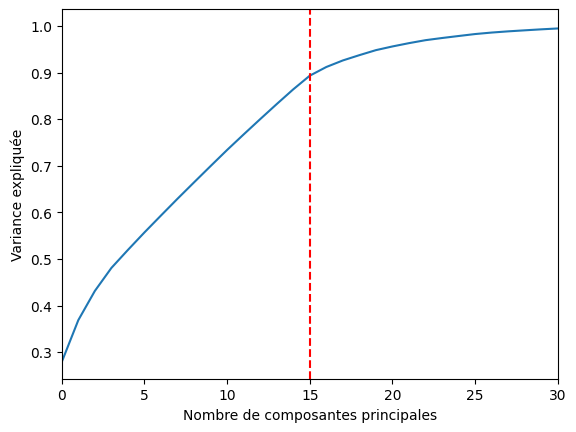

In [15]:
plot_pca(ethical_train_set_prepared_df)

C:\Users\mathi\AppData\Local\Temp\ipykernel_14880\3079959166.py:18: MatplotlibDeprecationWarning: Passing the emit parameter of set_xlim() positionally is deprecated since Matplotlib 3.6; the parameter will become keyword-only two minor releases later.
  plt.xlim(0, 30, 5)


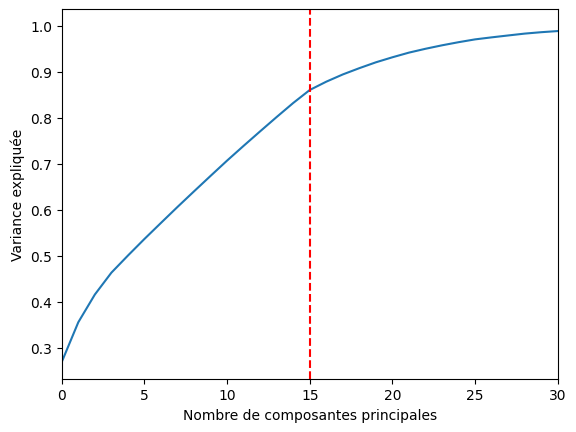

In [16]:
plot_pca(useful_train_set_prepared_df)

Pour les 2 jeux de données, la réduction de la dimentionnalité semble adaptée. Pour cela, nous allons utiliser l'ACP. Grace au graphique ci-dessus, nous pouvons voir que les 2 jeux de données sont très proches. Nous allons donc utiliser le même nombre de composantes pour les 2 jeux de données : **15**.

## Extraction de caractéristiques
Extraire les caractéristiques pertinentes des données brutes pour les utiliser dans l'apprentissage automatique.

## Sélection des modèles
Sélectionner le modèle d'apprentissage automatique le plus approprié pour le problème spécifique que l'on cherche à résoudre.

## Entraînement du modèle
Entraîner le modèle sélectionné sur les données d'entraînement en utilisant des algorithmes d'apprentissage automatique appropriés.

## Évaluation du modèle
Evaluer les performances du modèle sur des données de test pour mesurer sa précision, sa fiabilité et sa robustesse.

## Mise en production du modèle
Intégrer le modèle entraîné dans une application en temps réel pour effectuer des prédictions sur de nouvelles données.